# **Generating Images**

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

4422102/4422102 [==============================] - 1s 0us/step


(60000, 28, 28)

In [3]:
# reshaping for NN
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [4]:
train_images = (train_images - 127.5) / 127.5
print(train_images.min(), "---",train_images.max())

-1.0 --- 1.0


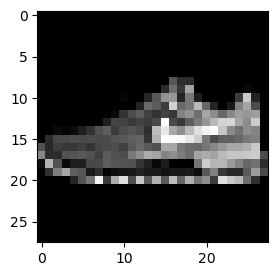

In [5]:
plt.figure(figsize=(3, 3))
plt.imshow(train_images[2567].squeeze(), cmap = 'gray')

In [6]:
buffer_size = 60000
batch_size = 128


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

\newpage

# CNN

In [25]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, input_shape = (100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
   
    model.add(layers.Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', activation = 'tanh'))
    
    return model

In [26]:
generator = generator_model()

generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu_3 (ReLU)              (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)       

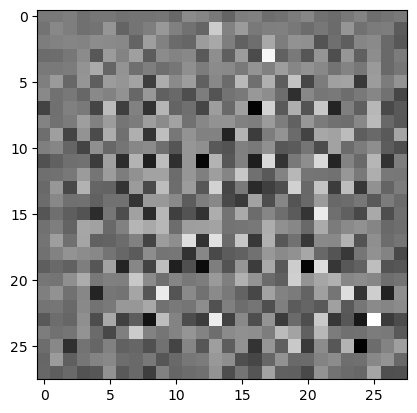

In [27]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

In [28]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same',
                            input_shape = [28, 28, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

In [29]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                      

In [30]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print (output)

tf.Tensor([[0.5004783]], shape=(1, 1), dtype=float32)


In [31]:
bce = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake_output):
    gen_loss = bce(tf.ones_like(fake_output), fake_output)
    
    return gen_loss

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [34]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [35]:
def generate_and_plot_images(model, epoch, test_input):
  
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (3, 3))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  
        pred = (predictions[i, :, :, 0] + 1) * 127.5  
        pred = np.array(pred)    
        plt.imshow(pred.astype(np.uint8), cmap = 'gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [36]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

\newpage

In [37]:
def train(dataset, epochs):
    gen_loss_list = []
    disc_loss_list = []
    
    real_score_list = []
    fake_score_list = []
    
    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)
        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches..')
        
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)
            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss
        
        mean_gen_loss = total_gen_loss/num_batches
        mean_disc_loss = total_disc_loss/num_batches
           
        print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real_score %.2f%%, fake_score %.2f%%' %
              (epoch + 1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        generate_and_plot_images(generator, epoch + 1, seed)         
        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list              


  0%|          | 0/50 [00:00<?, ?it/s]

Training started with  epoch 1 with 469 batches..


2023-11-11 08:23:28.103136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-11 08:23:39.313278: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Losses after epoch     1: generator 2.149, discriminator 0.553, real_score 76.13%, fake_score 16.47%


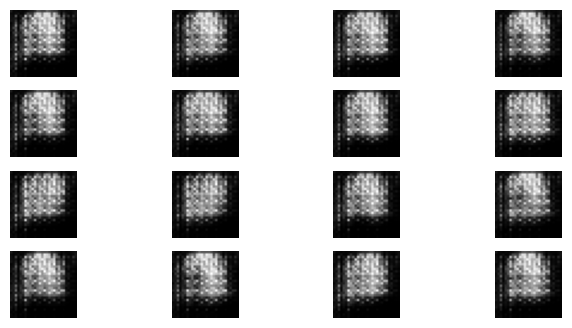

  2%|▏         | 1/50 [00:14<12:04, 14.78s/it]

Time for epoch 1 is 14.779123067855835 sec
Training started with  epoch 2 with 469 batches..
Losses after epoch     2: generator 1.481, discriminator 1.029, real_score 63.37%, fake_score 29.55%


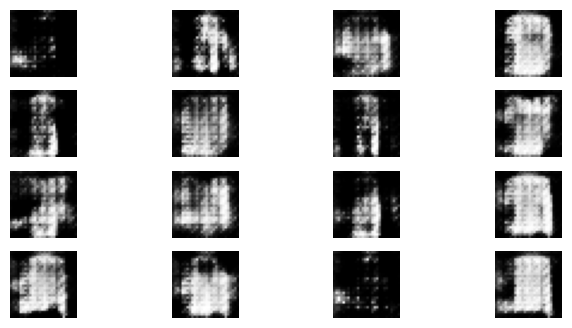

  4%|▍         | 2/50 [00:23<08:45, 10.95s/it]

Time for epoch 2 is 8.270374298095703 sec
Training started with  epoch 3 with 469 batches..
Losses after epoch     3: generator 1.177, discriminator 1.159, real_score 65.00%, fake_score 38.74%


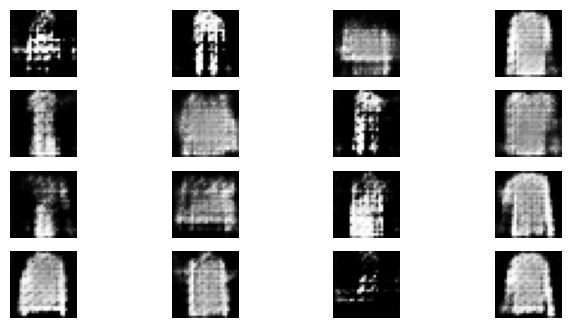

  6%|▌         | 3/50 [00:31<07:36,  9.71s/it]

Time for epoch 3 is 8.230552673339844 sec
Training started with  epoch 4 with 469 batches..
Losses after epoch     4: generator 1.678, discriminator 1.026, real_score 56.95%, fake_score 26.43%


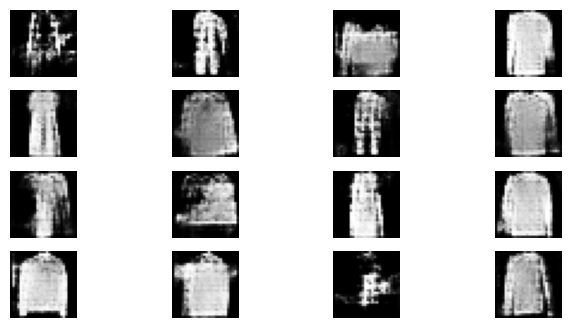

  8%|▊         | 4/50 [00:39<06:59,  9.13s/it]

Time for epoch 4 is 8.23097538948059 sec
Training started with  epoch 5 with 469 batches..
Losses after epoch     5: generator 1.066, discriminator 1.265, real_score 57.56%, fake_score 40.07%


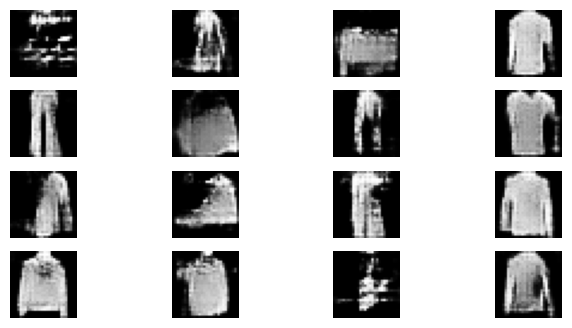

 10%|█         | 5/50 [00:48<06:40,  8.90s/it]

Time for epoch 5 is 8.50568151473999 sec
Training started with  epoch 6 with 469 batches..
Losses after epoch     6: generator 1.105, discriminator 1.115, real_score 61.56%, fake_score 38.20%


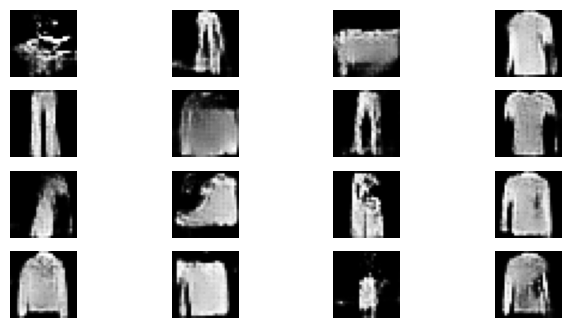

 12%|█▏        | 6/50 [00:56<06:20,  8.65s/it]

Time for epoch 6 is 8.171569347381592 sec
Training started with  epoch 7 with 469 batches..
Losses after epoch     7: generator 1.172, discriminator 1.180, real_score 56.44%, fake_score 36.40%


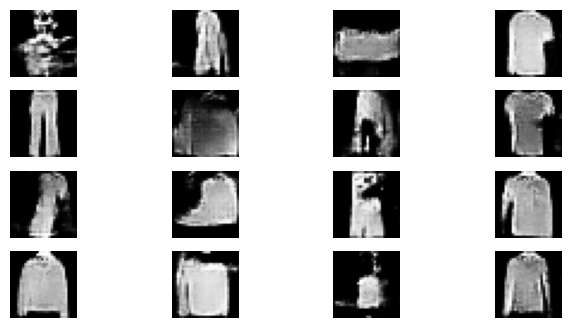

 14%|█▍        | 7/50 [01:04<06:06,  8.52s/it]

Time for epoch 7 is 8.226704597473145 sec
Training started with  epoch 8 with 469 batches..
Losses after epoch     8: generator 0.947, discriminator 1.184, real_score 62.20%, fake_score 43.84%


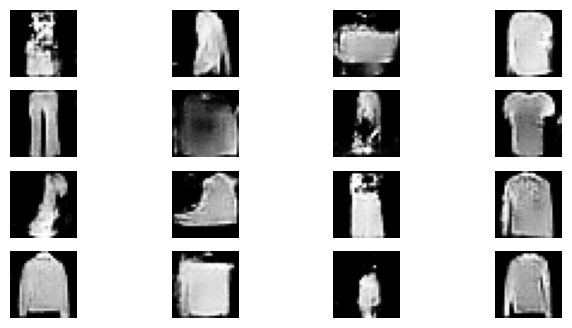

 16%|█▌        | 8/50 [01:12<05:53,  8.42s/it]

Time for epoch 8 is 8.218619108200073 sec
Training started with  epoch 9 with 469 batches..
Losses after epoch     9: generator 0.997, discriminator 1.177, real_score 59.19%, fake_score 41.20%


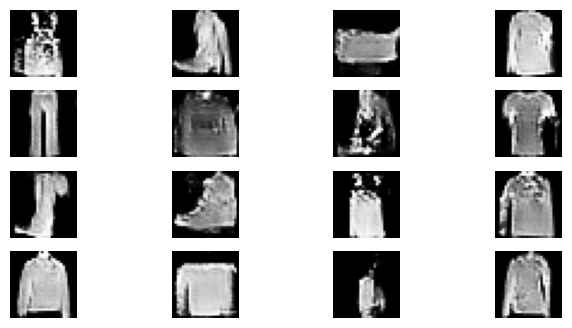

 18%|█▊        | 9/50 [01:20<05:42,  8.36s/it]

Time for epoch 9 is 8.225986003875732 sec
Training started with  epoch 10 with 469 batches..
Losses after epoch    10: generator 0.859, discriminator 1.164, real_score 65.35%, fake_score 46.33%


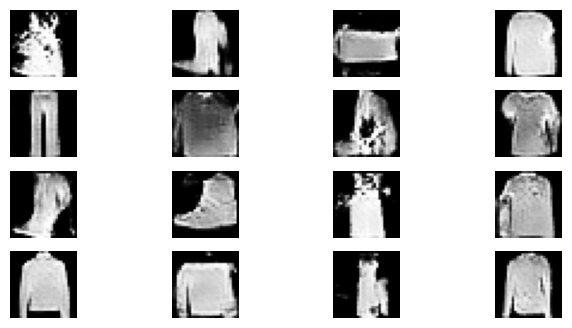

 20%|██        | 10/50 [01:29<05:39,  8.48s/it]

Time for epoch 10 is 8.751184940338135 sec
Training started with  epoch 11 with 469 batches..
Losses after epoch    11: generator 0.921, discriminator 1.252, real_score 57.95%, fake_score 44.43%


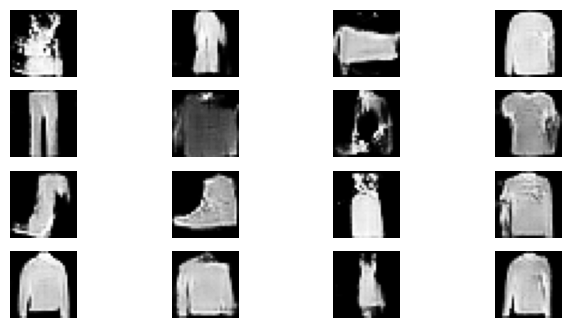

 22%|██▏       | 11/50 [01:37<05:27,  8.41s/it]

Time for epoch 11 is 8.244457721710205 sec
Training started with  epoch 12 with 469 batches..
Losses after epoch    12: generator 0.943, discriminator 1.297, real_score 53.81%, fake_score 42.89%


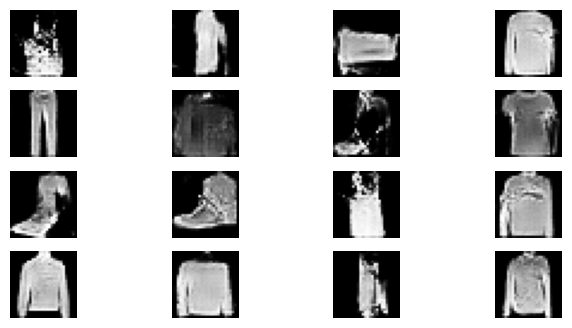

 24%|██▍       | 12/50 [01:46<05:16,  8.33s/it]

Time for epoch 12 is 8.160871267318726 sec
Training started with  epoch 13 with 469 batches..
Losses after epoch    13: generator 0.999, discriminator 1.304, real_score 50.73%, fake_score 40.43%


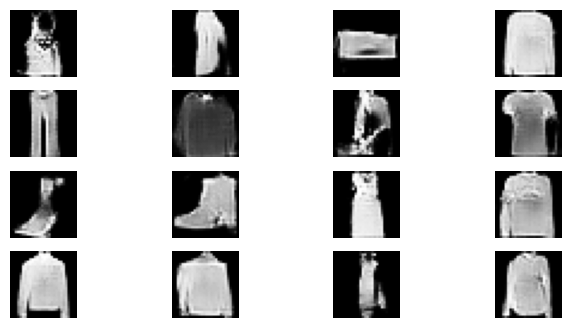

 26%|██▌       | 13/50 [01:54<05:06,  8.28s/it]

Time for epoch 13 is 8.158268690109253 sec
Training started with  epoch 14 with 469 batches..
Losses after epoch    14: generator 0.892, discriminator 1.321, real_score 55.10%, fake_score 45.18%


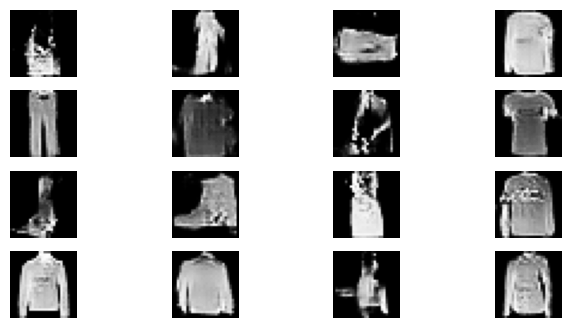

 28%|██▊       | 14/50 [02:02<05:00,  8.34s/it]

Time for epoch 14 is 8.457984685897827 sec
Training started with  epoch 15 with 469 batches..
Losses after epoch    15: generator 0.779, discriminator 1.359, real_score 56.35%, fake_score 48.74%


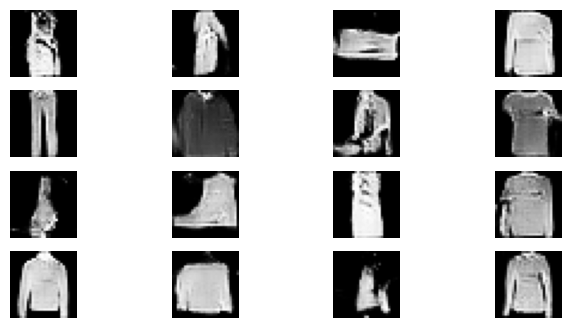

 30%|███       | 15/50 [02:10<04:50,  8.30s/it]

Time for epoch 15 is 8.200506448745728 sec
Training started with  epoch 16 with 469 batches..
Losses after epoch    16: generator 0.943, discriminator 1.313, real_score 53.17%, fake_score 42.57%


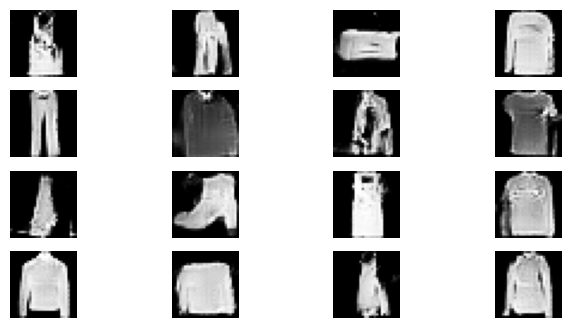

 32%|███▏      | 16/50 [02:19<04:41,  8.28s/it]

Time for epoch 16 is 8.23490858078003 sec
Training started with  epoch 17 with 469 batches..
Losses after epoch    17: generator 0.926, discriminator 1.290, real_score 52.28%, fake_score 42.50%


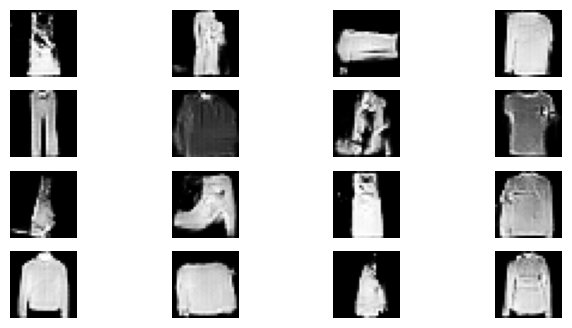

 34%|███▍      | 17/50 [02:27<04:32,  8.26s/it]

Time for epoch 17 is 8.222379207611084 sec
Training started with  epoch 18 with 469 batches..
Losses after epoch    18: generator 0.848, discriminator 1.312, real_score 54.16%, fake_score 45.40%


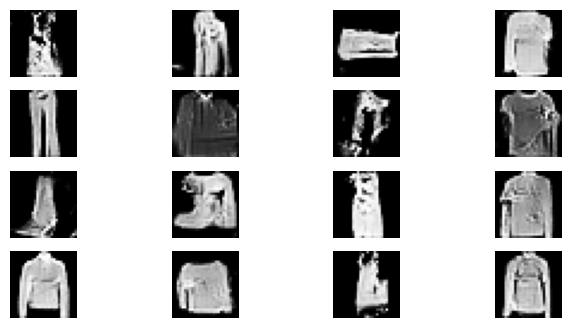

 36%|███▌      | 18/50 [02:38<04:48,  9.02s/it]

Time for epoch 18 is 10.789602518081665 sec
Training started with  epoch 19 with 469 batches..
Losses after epoch    19: generator 0.874, discriminator 1.258, real_score 56.12%, fake_score 44.20%


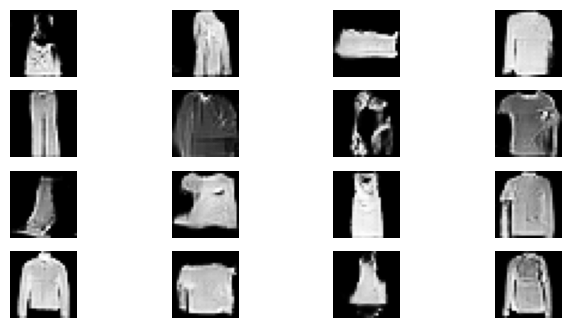

 38%|███▊      | 19/50 [02:46<04:35,  8.88s/it]

Time for epoch 19 is 8.530953168869019 sec
Training started with  epoch 20 with 469 batches..
Losses after epoch    20: generator 0.706, discriminator 1.371, real_score 57.22%, fake_score 51.35%


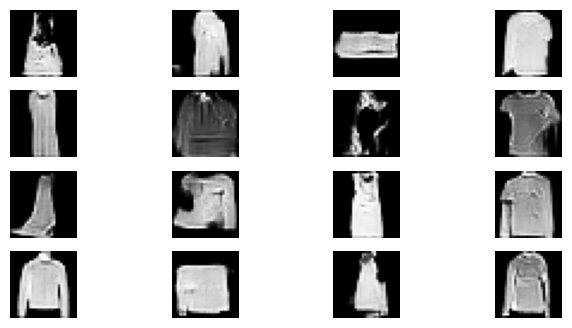

 40%|████      | 20/50 [02:55<04:22,  8.74s/it]

Time for epoch 20 is 8.408716201782227 sec
Training started with  epoch 21 with 469 batches..
Losses after epoch    21: generator 0.808, discriminator 1.306, real_score 55.47%, fake_score 46.99%


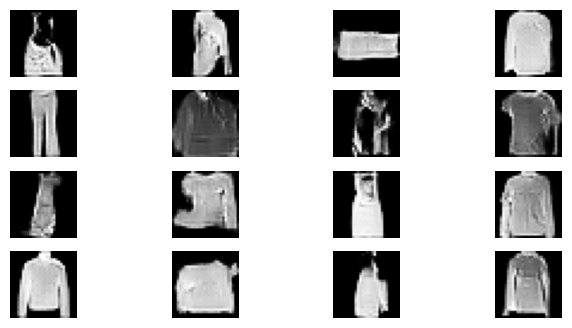

 42%|████▏     | 21/50 [03:03<04:08,  8.58s/it]

Time for epoch 21 is 8.227858304977417 sec
Training started with  epoch 22 with 469 batches..
Losses after epoch    22: generator 0.976, discriminator 1.273, real_score 49.96%, fake_score 39.90%


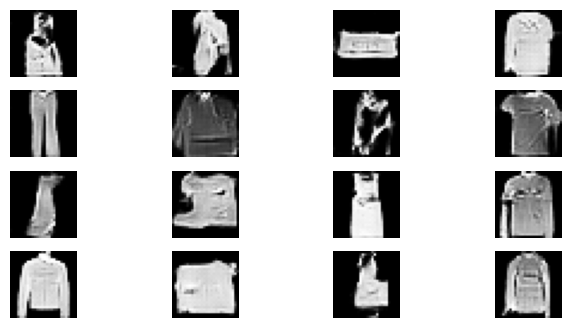

 44%|████▍     | 22/50 [03:11<03:57,  8.48s/it]

Time for epoch 22 is 8.234147071838379 sec
Training started with  epoch 23 with 469 batches..
Losses after epoch    23: generator 0.717, discriminator 1.398, real_score 55.26%, fake_score 51.10%


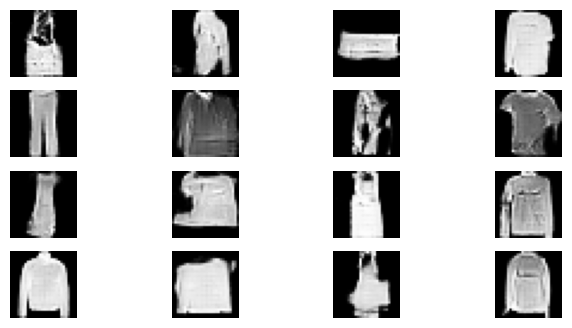

 46%|████▌     | 23/50 [03:20<03:49,  8.49s/it]

Time for epoch 23 is 8.50015926361084 sec
Training started with  epoch 24 with 469 batches..
Losses after epoch    24: generator 0.920, discriminator 1.237, real_score 53.84%, fake_score 42.42%


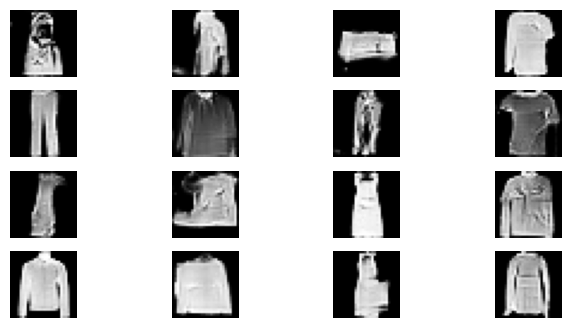

 48%|████▊     | 24/50 [03:28<03:38,  8.41s/it]

Time for epoch 24 is 8.232375383377075 sec
Training started with  epoch 25 with 469 batches..
Losses after epoch    25: generator 0.772, discriminator 1.331, real_score 56.08%, fake_score 48.44%


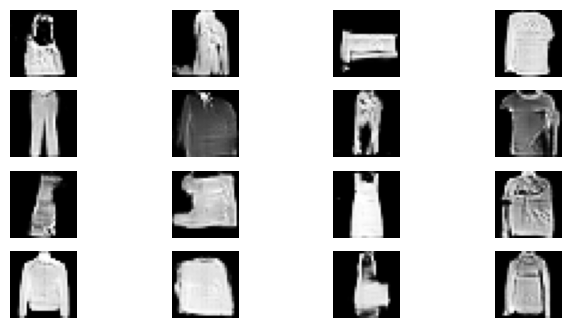

 50%|█████     | 25/50 [03:36<03:28,  8.35s/it]

Time for epoch 25 is 8.216292142868042 sec
Training started with  epoch 26 with 469 batches..
Losses after epoch    26: generator 0.821, discriminator 1.263, real_score 55.79%, fake_score 46.08%


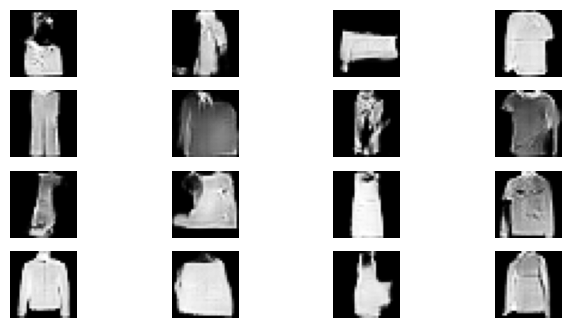

 52%|█████▏    | 26/50 [03:44<03:19,  8.29s/it]

Time for epoch 26 is 8.156019449234009 sec
Training started with  epoch 27 with 469 batches..
Losses after epoch    27: generator 0.878, discriminator 1.289, real_score 52.71%, fake_score 43.71%


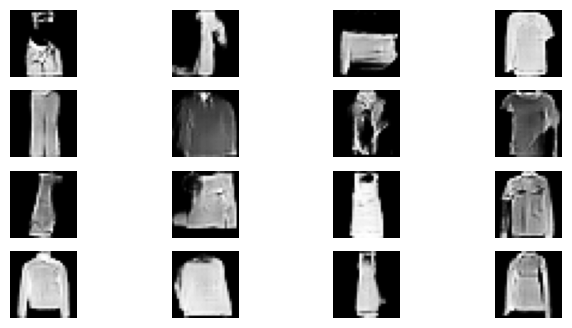

 54%|█████▍    | 27/50 [03:52<03:10,  8.28s/it]

Time for epoch 27 is 8.234407186508179 sec
Training started with  epoch 28 with 469 batches..
Losses after epoch    28: generator 0.817, discriminator 1.376, real_score 51.17%, fake_score 46.20%


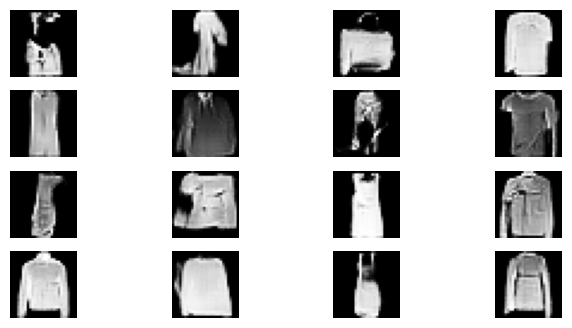

 56%|█████▌    | 28/50 [04:01<03:03,  8.36s/it]

Time for epoch 28 is 8.556233406066895 sec
Training started with  epoch 29 with 469 batches..
Losses after epoch    29: generator 0.903, discriminator 1.290, real_score 51.42%, fake_score 42.92%


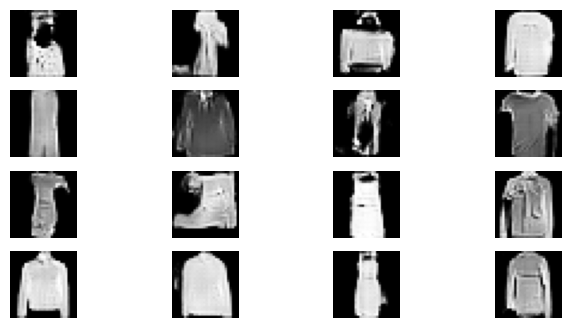

 58%|█████▊    | 29/50 [04:09<02:54,  8.32s/it]

Time for epoch 29 is 8.223681211471558 sec
Training started with  epoch 30 with 469 batches..
Losses after epoch    30: generator 0.864, discriminator 1.334, real_score 51.76%, fake_score 44.55%


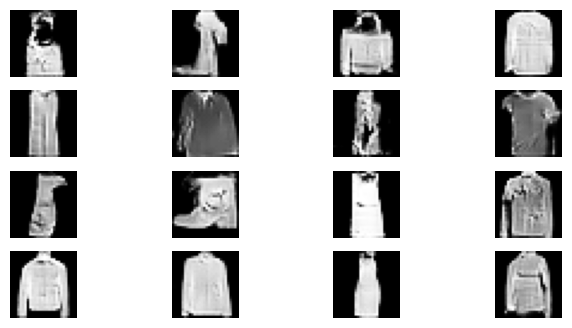

 60%|██████    | 30/50 [04:18<02:47,  8.35s/it]

Time for epoch 30 is 8.425201654434204 sec
Training started with  epoch 31 with 469 batches..
Losses after epoch    31: generator 0.968, discriminator 1.192, real_score 53.56%, fake_score 40.15%


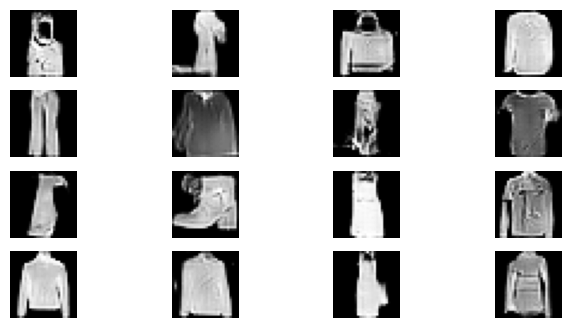

 62%|██████▏   | 31/50 [04:26<02:37,  8.31s/it]

Time for epoch 31 is 8.226038694381714 sec
Training started with  epoch 32 with 469 batches..
Losses after epoch    32: generator 0.951, discriminator 1.229, real_score 52.18%, fake_score 40.38%


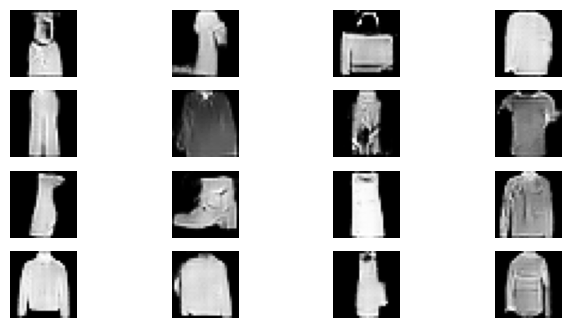

 64%|██████▍   | 32/50 [04:34<02:29,  8.29s/it]

Time for epoch 32 is 8.218490362167358 sec
Training started with  epoch 33 with 469 batches..
Losses after epoch    33: generator 0.822, discriminator 1.402, real_score 50.07%, fake_score 46.43%


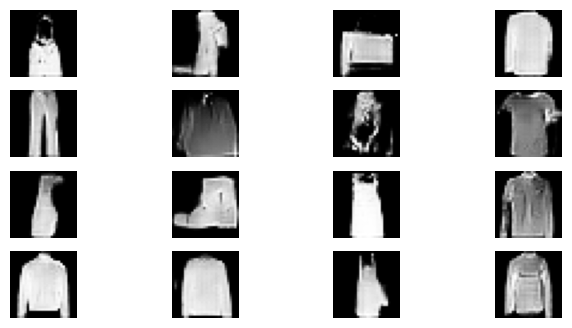

 66%|██████▌   | 33/50 [04:43<02:22,  8.36s/it]

Time for epoch 33 is 8.536447525024414 sec
Training started with  epoch 34 with 469 batches..
Losses after epoch    34: generator 0.931, discriminator 1.257, real_score 52.61%, fake_score 41.82%


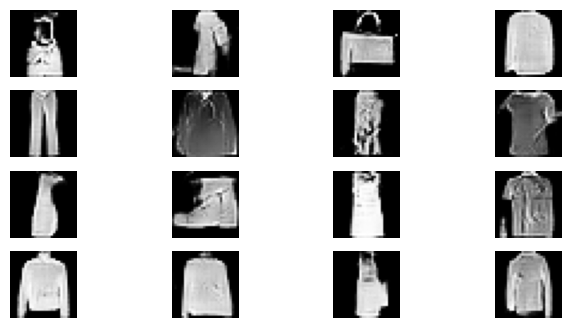

 68%|██████▊   | 34/50 [04:51<02:13,  8.32s/it]

Time for epoch 34 is 8.222845554351807 sec
Training started with  epoch 35 with 469 batches..
Losses after epoch    35: generator 0.819, discriminator 1.323, real_score 52.29%, fake_score 45.79%


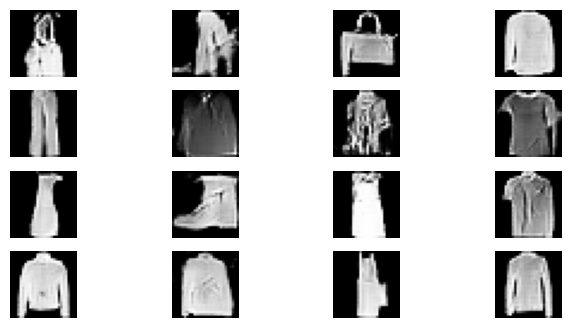

 70%|███████   | 35/50 [04:59<02:04,  8.29s/it]

Time for epoch 35 is 8.225217342376709 sec
Training started with  epoch 36 with 469 batches..
Losses after epoch    36: generator 0.793, discriminator 1.312, real_score 54.09%, fake_score 47.02%


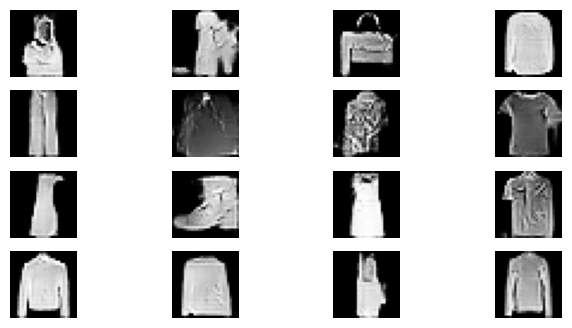

 72%|███████▏  | 36/50 [05:07<01:55,  8.28s/it]

Time for epoch 36 is 8.23757791519165 sec
Training started with  epoch 37 with 469 batches..
Losses after epoch    37: generator 0.918, discriminator 1.267, real_score 51.57%, fake_score 42.07%


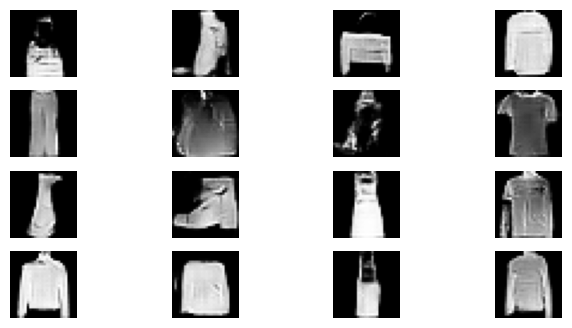

 74%|███████▍  | 37/50 [05:16<01:48,  8.35s/it]

Time for epoch 37 is 8.514817714691162 sec
Training started with  epoch 38 with 469 batches..
Losses after epoch    38: generator 0.722, discriminator 1.428, real_score 51.78%, fake_score 50.39%


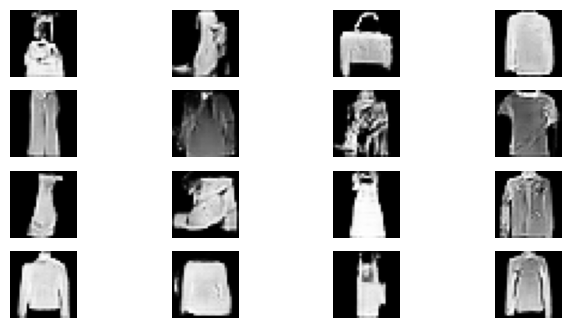

 76%|███████▌  | 38/50 [05:24<01:39,  8.32s/it]

Time for epoch 38 is 8.249526739120483 sec
Training started with  epoch 39 with 469 batches..
Losses after epoch    39: generator 0.918, discriminator 1.284, real_score 50.46%, fake_score 41.84%


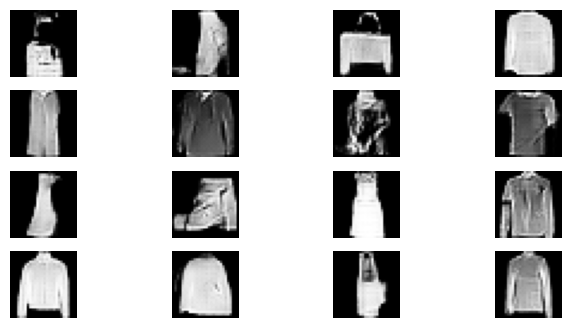

 78%|███████▊  | 39/50 [05:32<01:31,  8.30s/it]

Time for epoch 39 is 8.244988441467285 sec
Training started with  epoch 40 with 469 batches..
Losses after epoch    40: generator 0.804, discriminator 1.328, real_score 52.98%, fake_score 46.44%


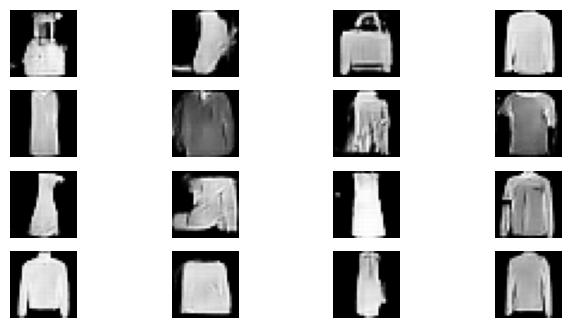

 80%|████████  | 40/50 [05:41<01:23,  8.31s/it]

Time for epoch 40 is 8.341033458709717 sec
Training started with  epoch 41 with 469 batches..
Losses after epoch    41: generator 0.931, discriminator 1.331, real_score 49.16%, fake_score 42.08%


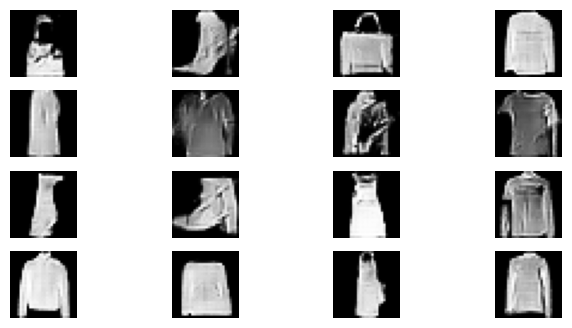

 82%|████████▏ | 41/50 [05:49<01:14,  8.29s/it]

Time for epoch 41 is 8.234814167022705 sec
Training started with  epoch 42 with 469 batches..
Losses after epoch    42: generator 0.790, discriminator 1.336, real_score 53.52%, fake_score 47.27%


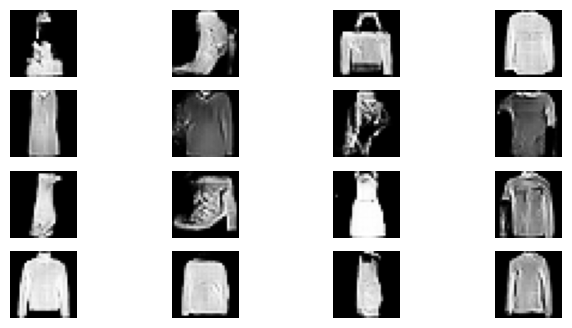

 84%|████████▍ | 42/50 [05:57<01:06,  8.35s/it]

Time for epoch 42 is 8.479984045028687 sec
Training started with  epoch 43 with 469 batches..
Losses after epoch    43: generator 0.900, discriminator 1.474, real_score 44.84%, fake_score 43.63%


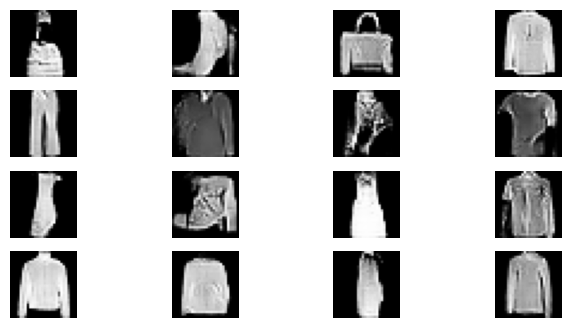

 86%|████████▌ | 43/50 [06:06<00:58,  8.31s/it]

Time for epoch 43 is 8.234028100967407 sec
Training started with  epoch 44 with 469 batches..
Losses after epoch    44: generator 0.831, discriminator 1.275, real_score 54.58%, fake_score 45.51%


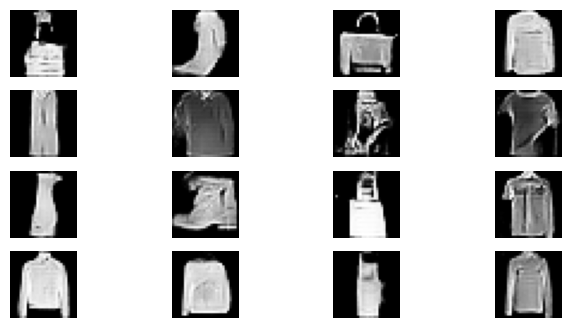

 88%|████████▊ | 44/50 [06:14<00:49,  8.30s/it]

Time for epoch 44 is 8.252701759338379 sec
Training started with  epoch 45 with 469 batches..
Losses after epoch    45: generator 0.818, discriminator 1.312, real_score 53.68%, fake_score 46.18%


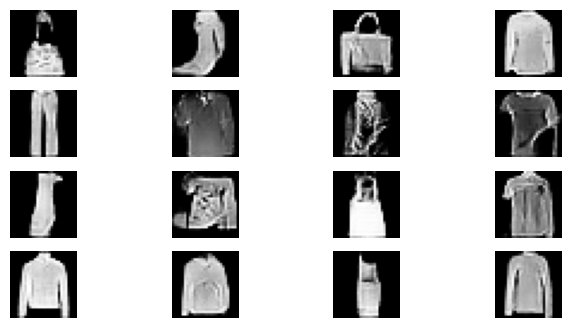

 90%|█████████ | 45/50 [06:22<00:41,  8.28s/it]

Time for epoch 45 is 8.236793279647827 sec
Training started with  epoch 46 with 469 batches..
Losses after epoch    46: generator 0.928, discriminator 1.270, real_score 50.99%, fake_score 41.60%


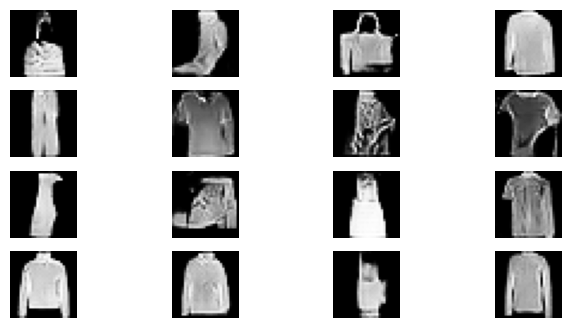

 92%|█████████▏| 46/50 [06:31<00:33,  8.33s/it]

Time for epoch 46 is 8.450302124023438 sec
Training started with  epoch 47 with 469 batches..
Losses after epoch    47: generator 0.866, discriminator 1.282, real_score 53.32%, fake_score 44.06%


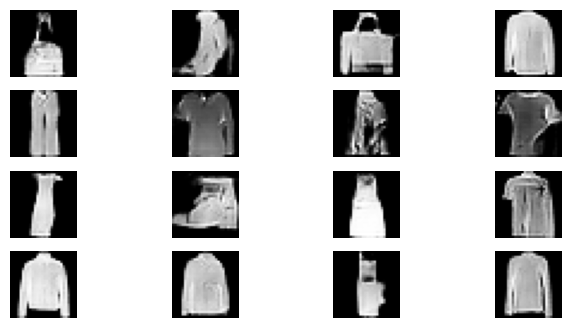

 94%|█████████▍| 47/50 [06:39<00:24,  8.30s/it]

Time for epoch 47 is 8.218152284622192 sec
Training started with  epoch 48 with 469 batches..
Losses after epoch    48: generator 0.843, discriminator 1.394, real_score 50.19%, fake_score 45.98%


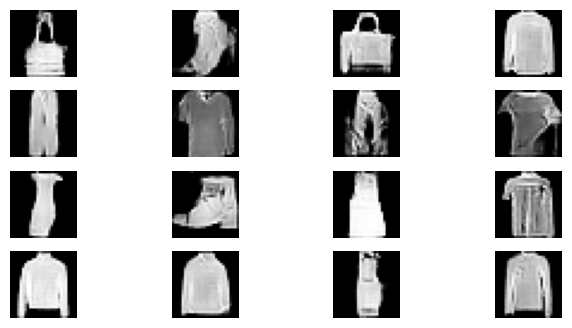

 96%|█████████▌| 48/50 [06:47<00:16,  8.26s/it]

Time for epoch 48 is 8.171672105789185 sec
Training started with  epoch 49 with 469 batches..
Losses after epoch    49: generator 0.876, discriminator 1.339, real_score 50.27%, fake_score 43.87%


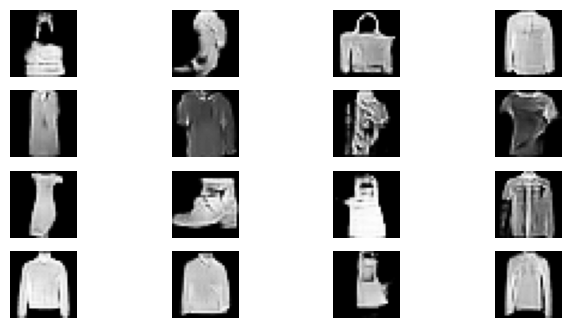

 98%|█████████▊| 49/50 [06:55<00:08,  8.26s/it]

Time for epoch 49 is 8.261276245117188 sec
Training started with  epoch 50 with 469 batches..
Losses after epoch    50: generator 0.786, discriminator 1.339, real_score 54.32%, fake_score 47.72%


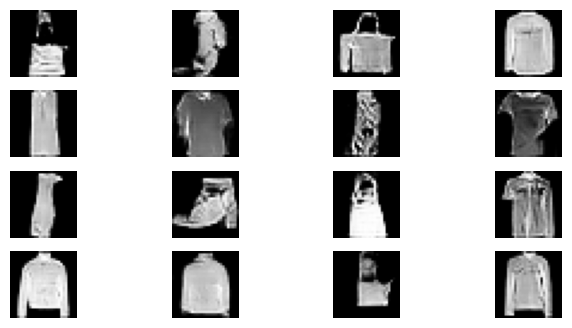

100%|██████████| 50/50 [07:04<00:00,  8.49s/it]

Time for epoch 50 is 8.708526849746704 sec


In [38]:
gen_loss_epochs, disc_loss_epochs,real_score_list,fake_score_list = train(train_dataset, epochs = epochs)


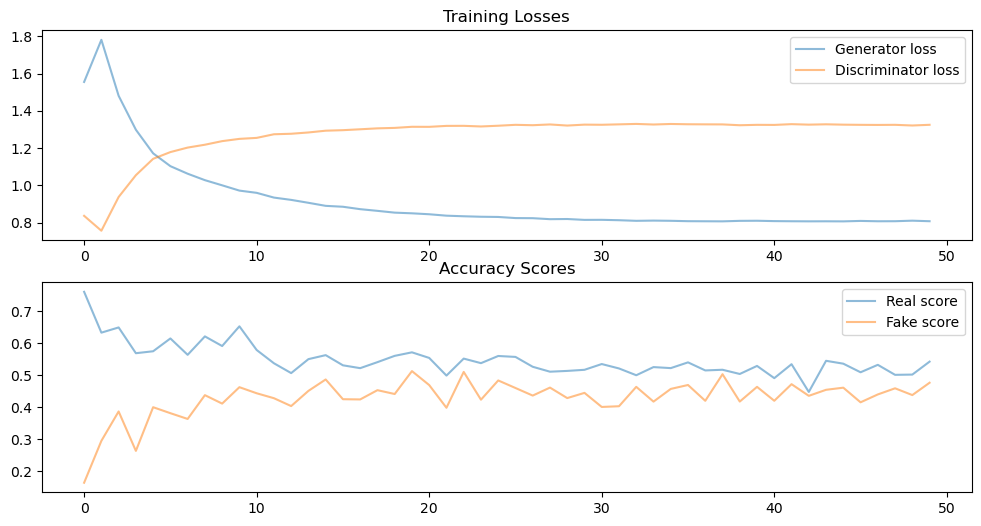

In [39]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize = (12,6))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()

#### 